In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Data Import
 * Import data
 * Feature processing
 * Scaling/imputation for neural networks

This uses the same dataset as [Exploring Hierarchical Blending in Target Encoding](https://medium.com/towards-data-science/exploring-hierarchical-blending-in-target-encoding-fea4c59b305b).  See the repository https://github.com/vla6/Blog_gnn_naics

I will create two datasets - one with missing NAICS, and one without

*This script takes about 1 minute on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import re, pickle, importlib
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from sklearn.model_selection import train_test_split

In [4]:
# Imputer object for easy dataset conversion to NN friendly format
from sba_nn.sba_nn import sbnn_imputer 
from sba_nn.sba_nn.sbnn_imputer import NNImputer

## Import Data

##### Loans Data - See README.md

In [5]:
sba_loans = pd.read_csv(setup.input_path,  dtype=setup.input_dtypes, 
                        parse_dates = setup.input_dates, date_format='%d-%b-%y',
                        converters = setup.input_converters)

##### NAICS map

In [6]:
naics_map = pd.read_csv('naics/naics_map.csv', dtype='str', encoding='latin1' ) \
    .rename(columns={'Sector': 'NAICS_sector',
                     'Description': 'NAICS_sector_desc'})

In [7]:
naics_map[['NAICS_sector', 'NAICS_sector_desc']] = naics_map[['NAICS_sector', 'NAICS_sector_desc']] \
    .apply(lambda x: x.astype('category'))

In [8]:
naics_map.head(5)

,NAICS_sector,NAICS_2,NAICS_sector_desc
0,11,11,"Agriculture, Forestry, Fishing and Hunting"
1,21,21,"Mining, Quarrying, and Oil and Gas Extraction"
2,22,22,Utilities
3,23,23,Construction
4,31-33,31,Manufacturing


##### All NAICS Descriptions (2007)

In [9]:
naics_desc = pd.read_csv('naics/naics_2007.csv', dtype='str', encoding='latin1' ) \
    .rename(columns={'INDEX ITEM DESCRIPTION': 'NAICS07_desc'})

In [10]:
naics_desc.sample(4)

,NAICS07,NAICS07_desc
3236,312140,Blending distilled beverages (except brandy)
3294,313112,Beaming yarn
4853,316991,"Valises, all materials, manufacturing"
10835,334513,"Differential pressure instruments, industrial ..."


In [11]:
naics_desc.to_parquet(Path(setup.temp_path).joinpath('01_DATA_naics07_descriptions.parquet'))

## Process Target

##### Create the target feature (0/1) that indicates a default

In [12]:
# The loans with unknown MIS Status are a small count, most don't have charge-off dates but some do
# Drop these rows as they are ambiguous and small volume
sba_loans = sba_loans[~sba_loans['MIS_Status'].isna()]

In [13]:
# Create a binary feature for the remaining loans
sba_loans['target'] = np.where(sba_loans['MIS_Status'] == 'P I F', 0, 1)

In [14]:
sba_loans['target'].value_counts(dropna=False, normalize=True)

target
0    0.824383
1    0.175617
Name: proportion, dtype: float64

## Predictor Features - Basic Processing

##### Convert approval year to a date

In [15]:
sba_loans['ApprovalFY'] = sba_loans['ApprovalFY'].str[0:4].astype('int')
sba_loans['ApprovalFY'].describe()

count    897167.000000
mean       2001.139677
std           5.912461
min        1966.000000
25%        1997.000000
50%        2002.000000
75%        2006.000000
max        2014.000000
Name: ApprovalFY, dtype: float64

##### Express SBA guaranteed amount as a fraction

In [16]:
sba_loans['guaranteed_fract'] = sba_loans['SBA_Appv']/sba_loans['GrAppv']

##### Convert Y/N binary columns

In [17]:
# Function to convert 'Y','N' columns
def convert_yn(ser):
    cond = [ser.isna(), ser.str.lower() == 'y', ser.str.lower() == 'n']
    choice =[np.nan, 1, 0]
    return np.select(cond, choice, np.nan)

In [18]:
sba_loans['RevLineCr'] = convert_yn(sba_loans['RevLineCr'])
sba_loans['RevLineCr'].value_counts(dropna=False)

RevLineCr
0.0    419252
NaN    277255
1.0    200660
Name: count, dtype: int64

In [19]:
sba_loans['LowDoc'] = convert_yn(sba_loans['LowDoc'])
sba_loans['LowDoc'].value_counts(dropna=False)

LowDoc
0.0    780997
1.0    110171
NaN      5999
Name: count, dtype: int64

##### New/existing business

In [20]:
cond = [sba_loans['NewExist'].isna(), sba_loans['NewExist'] == '1', sba_loans['NewExist'] == '2']
choice = [np.nan, 0, 1]
sba_loans['new_business'] = np.select(cond, choice, np.nan)

##### Urban/Rural

In [21]:
sba_loans['UrbanRural'].value_counts(dropna=False)

UrbanRural
1    469281
0    322826
2    105060
Name: count, dtype: int64

In [22]:
cond = [sba_loans['UrbanRural'].isna(), sba_loans['UrbanRural'] == '1', sba_loans['UrbanRural'] == '2']
choice = [np.nan, 1, 0]
sba_loans['urban_flag'] = np.select(cond, choice, np.nan)

##### Franchise flag

In [23]:
cond = [sba_loans['FranchiseCode'].isna(), sba_loans['FranchiseCode'].isin(['1', '0', '00000', '00001'])]
choice = [np.nan, 0]
sba_loans['franchise_flag'] = np.select(cond, choice, 1)

## NAICS

I use 2007 NAICS definitions as this data spans a range of timeframes, with median ~2009; however this one vintage may not perfectly reflect the data. See also https://www.census.gov/naics/?48967

##### Clean up

In [24]:
# Make '0' NAICS NA
sba_loans['NAICS'] = sba_loans['NAICS'].where(sba_loans['NAICS'] != '0', np.nan)
sba_loans['NAICS'].value_counts(dropna=False)

NAICS
NaN       201667
722110     27941
722211     19435
811111     14539
621210     14034
           ...  
212231         1
925120         1
524192         1
311351         1
333241         1
Name: count, Length: 1312, dtype: int64

In [25]:
# Length of remaining codes
sba_loans['NAICS'].str.len().value_counts()
# They all have the right number of digits!

NAICS
6.0    695500
Name: count, dtype: int64

##### Add the NAICS hierarcy information

In [26]:
sba_loans['NAICS_2'] = sba_loans['NAICS'].str[0:2]
sba_loans['NAICS_3'] = sba_loans['NAICS'].str[0:3]
sba_loans['NAICS_4'] = sba_loans['NAICS'].str[0:4]
sba_loans['NAICS_5'] = sba_loans['NAICS'].str[0:5]

In [27]:
sba_loans = sba_loans \
    .drop(columns=['NAICS_sector', 'NAICS_sector_desc'], errors='ignore') \
    .merge(naics_map, on='NAICS_2', how='left')

## Missingness
Quick plot showing that missing NAICS are mostly older loans

In [28]:
sba_loans['missing_NAICS'] = np.where(sba_loans['NAICS'].isna(), 1, 0)

In [29]:
sba_loans.groupby('missing_NAICS')['ApprovalFY'].agg(['median', 'mean', 'min', 'max'])

,median,mean,min,max
missing_NAICS,,,,
0,2004.0,2003.018242,1984,2014
1,1995.0,1994.660971,1966,2010


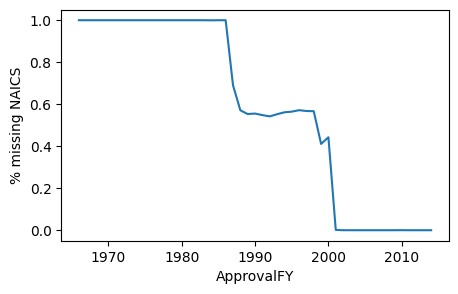

In [30]:
# Plot NAICS missingness
fig, ax = plt.subplots(figsize = (5, 3))
sba_loans.groupby('ApprovalFY')['missing_NAICS'].agg('mean').plot(ax = ax)
ax.set_ylabel('% missing NAICS')
plt.gcf().savefig(Path(setup.temp_path).joinpath('01_PLOT_loan_year_NAICS_missing.png'),bbox_inches='tight')

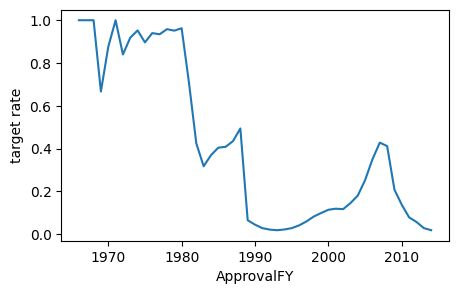

In [31]:
# Plot target rate
fig, ax = plt.subplots(figsize = (5, 3))
sba_loans.groupby('ApprovalFY')['target'].agg('mean').plot(ax = ax)
ax.set_ylabel('target rate')
plt.gcf().savefig(Path(setup.temp_path).joinpath('01_PLOT_loan_year_target_rate.png'),bbox_inches='tight')

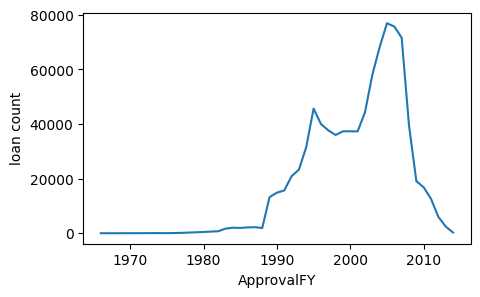

In [32]:
# Plot loan count
# Plot NAICS missingness
fig, ax = plt.subplots(figsize = (5, 3))
sba_loans.groupby('ApprovalFY')['target'].agg('count').plot(ax = ax)
ax.set_ylabel('loan count')
plt.gcf().savefig(Path(setup.temp_path).joinpath('01_PLOT_loan_year_counts.png'),bbox_inches='tight')

Loans prior to 1990 are rare and also have super high default rates, and often-null NAICS.  I think these loans are probably very different from more modern loans. 

##### Save dataset so far

In [33]:
sba_loans.to_parquet(Path(setup.temp_path).joinpath('01_DATA_import_filtered.parquet'))

## Train/Test Split
Split prior to encoding. I will do a 70/15/15 split.  

I will put all cases for a few NAICS into the test data set, to test the effect of encodings on unseen codes.

In [34]:
holdout_naics = sba_loans[['NAICS']].drop_duplicates().sample(frac=0.10, random_state =2432)
holdout_naics.to_csv(Path(setup.temp_path).joinpath('01_REPORT_holdout_naics.csv'))
holdout_naics.shape

(131, 1)

In [35]:
sba_merge = sba_loans[['LoanNr_ChkDgt', 'NAICS']].reset_index() \
    .merge(holdout_naics, on='NAICS', how='left', indicator=True) \
    .set_index('index')
sba_holdout_naics_index = sba_merge[sba_merge['_merge'] == 'both'].index
sba_allow_naics_index = sba_merge[sba_merge['_merge'] == 'left_only'].index

In [36]:
[train_index, other_index] = train_test_split(sba_allow_naics_index, 
                                              train_size=0.70, random_state=2343)

In [37]:
[val_index, test_split_ind] = train_test_split(other_index, 
                                               train_size=0.50, random_state=2343)

In [38]:
test_index = test_split_ind.union(sba_holdout_naics_index)

In [39]:
print(f'train index: {train_index.shape}, validation index: {val_index.shape}, test index: {test_index.shape}')
print(f'test regular split: {test_split_ind.shape}, NAICS holdout:{sba_holdout_naics_index.shape}')
print(f'total: {len(train_index) + len(val_index) + len(test_index)}')

train index: (587773,), validation index: (125951,), test index: (183443,)
test regular split: (125952,), NAICS holdout:(57491,)
total: 897167


In [40]:
cond= [sba_loans.index.isin(train_index), sba_loans.index.isin(val_index)]
choice=['train', 'val']
sba_loans['dset'] = np.select(cond, choice, 'test')

In [41]:
cond= [~sba_loans.index.isin(test_index), sba_loans.index.isin(sba_holdout_naics_index)]
choice=[np.nan, 1]
sba_loans['dset_naics_holdout'] = np.select(cond, choice, 0)

In [42]:
sba_loans['dset'].value_counts()

dset
train    587773
test     183443
val      125951
Name: count, dtype: int64

In [43]:
sba_loans['dset_naics_holdout'].value_counts(dropna=False)

dset_naics_holdout
NaN    713724
0.0    125952
1.0     57491
Name: count, dtype: int64

In [44]:
pd.crosstab(sba_loans['dset_naics_holdout'].fillna(-1), sba_loans['dset'], dropna=False)

dset,test,train,val
dset_naics_holdout,,,
-1.0,0,587773,125951
0.0,125952,0,0
1.0,57491,0,0


## Neural Network Imputing/Scaling/Encoding

For a neural network, I need to handle missings and also scale features.  For missing values, I will do a simple median fill for all, but add missing indicators.  

To scale the data, I will do a quantile transform for features with > 5 levels.  This is to avoid scaling binary features.  Then I do a Min/Max scaling on all features, so they are in the [0,1] range

I define a class to do this in sbnn_imputer.  This class wraps several scikit-learn imputers/scalers so that I can easily fit the objects and then transform the data.  

For NAICS, I need to integer encode for input into entity embeddings later.  I will reserve values 0 and 1 for missing/unseen codes.

##### Create imputer to do the median fill and scaling
This imputer fills missing values, adding missingness indicator features.  Then it quantile scales features with over 5 levels, and MinMax scales the rest.

In [45]:
importlib.reload(sbnn_imputer)
from sba_nn.sba_nn.sbnn_imputer import NNImputer

In [46]:
train_df = sba_loans[sba_loans['dset'] == 'train']

In [47]:
naics_features = ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
imputer = NNImputer(features = setup.predictor_features, naics_features = naics_features)                               

In [48]:
train_out = imputer.fit_transform(train_df)

In [49]:
nn_feat_desc = train_out.describe()
nn_feat_desc

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,missingindicator_LowDoc,missingindicator_new_business,missingindicator_urban_flag,NAICS,NAICS_5,NAICS_4,NAICS_3,NAICS_sector
count,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000,587773.000000
mean,-0.006563,-0.491169,-0.749934,0.002386,-0.434094,0.773195,-0.882094,-0.986770,-0.997513,-0.267023,594.021537,369.835581,164.377913,48.219350,8.963826
std,0.573287,0.783879,0.661513,0.575398,0.900868,0.634169,0.471074,0.162124,0.070488,0.963691,433.815550,277.438459,123.022469,36.641454,6.875032
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.499499,-1.000000,-1.000000,-0.493593,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,87.000000,53.000000,29.000000,11.000000,5.000000
50%,-0.060060,-1.000000,-1.000000,0.021021,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,720.000000,426.000000,181.000000,48.000000,8.000000
75%,0.464464,0.468468,-1.000000,0.498498,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,1002.000000,639.000000,278.000000,84.000000,15.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1170.000000,764.000000,345.000000,107.000000,21.000000


In [50]:
with open(Path(setup.temp_path).joinpath('01_DATA_imputer.pkl'), 'wb') as fout:
    pickle.dump(imputer, fout)

In [51]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'wb') as fout:
    pickle.dump(imputer.features_out, fout)

In [52]:
nn_feat_desc.to_csv(Path(setup.temp_path).joinpath('01_DATA_descriptives'), index=True)

##### Save the max encoding value for NAICS features
This is crucial for creating entity embeddings, as I have to pass this value to the embedding layer constructor

In [53]:
len_dict = nn_feat_desc[nn_feat_desc.index == 'max'][naics_features] \
    .astype(int).to_dict(orient='index')['max']
print(len_dict)

{'NAICS': 1170, 'NAICS_5': 764, 'NAICS_4': 345, 'NAICS_3': 107, 'NAICS_sector': 21}


In [54]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'wb') as fout:
    pickle.dump(len_dict, fout)

##### Transform Test, Validation Data

In [55]:
test_val_df = sba_loans[sba_loans['dset'] != 'train']

In [56]:
test_val_out = imputer.transform(test_val_df)

In [57]:
test_val_out.describe()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,missingindicator_LowDoc,missingindicator_new_business,missingindicator_urban_flag,NAICS,NAICS_5,NAICS_4,NAICS_3,NAICS_sector
count,309394.000000,309394.000000,309394.000000,309394.000000,309394.000000,309394.00000,309394.000000,309394.000000,309394.000000,309394.000000,309394.000000,309394.000000,309394.000000,309394.000000,309394.000000
mean,-0.018301,-0.487542,-0.762891,-0.000757,-0.442478,0.75174,-0.889584,-0.986354,-0.997214,-0.305649,482.273308,326.270600,164.112216,48.884144,9.215680
std,0.573235,0.784196,0.646528,0.576450,0.896781,0.65946,0.456772,0.164639,0.074595,0.952146,454.441552,286.319541,122.801496,35.937895,6.744213
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.499499,-1.000000,-1.000000,-0.498498,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,35.000000,14.000000,5.000000
50%,-0.060060,-1.000000,-1.000000,0.021021,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,554.000000,357.000000,179.000000,47.000000,8.000000
75%,0.464464,0.468468,-1.000000,0.497998,1.000000,1.00000,-1.000000,-1.000000,-1.000000,1.000000,947.000000,620.000000,286.000000,86.000000,16.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1170.000000,764.000000,345.000000,107.000000,21.000000


In [58]:
nn_enc_df = pd.concat([train_out, test_val_out], axis=0).sort_index()

## Combine data
Append the information to the loans dataset.  Rename the original features

In [59]:
orig_dict = dict(zip(imputer.features_out,
                     [c + '_orig' for c in imputer.features_out]))
orig_dict

{'NoEmp': 'NoEmp_orig',
 'CreateJob': 'CreateJob_orig',
 'LowDoc': 'LowDoc_orig',
 'DisbursementGross': 'DisbursementGross_orig',
 'new_business': 'new_business_orig',
 'urban_flag': 'urban_flag_orig',
 'franchise_flag': 'franchise_flag_orig',
 'missingindicator_LowDoc': 'missingindicator_LowDoc_orig',
 'missingindicator_new_business': 'missingindicator_new_business_orig',
 'missingindicator_urban_flag': 'missingindicator_urban_flag_orig',
 'NAICS': 'NAICS_orig',
 'NAICS_5': 'NAICS_5_orig',
 'NAICS_4': 'NAICS_4_orig',
 'NAICS_3': 'NAICS_3_orig',
 'NAICS_sector': 'NAICS_sector_orig'}

In [60]:
sba_loans_out = pd.concat([sba_loans.rename(columns=orig_dict, errors='ignore') \
                           .sort_index(),
                           nn_enc_df], axis=1)

In [70]:
# Show unseen counts - should be none in train
pd.crosstab(sba_loans_out['dset'], sba_loans_out['NAICS'] == 1)

NAICS,False,True
dset,,
test,125947,57496
train,587773,0
val,125940,11


In [71]:
# Show unseen counts - all holdout are unseen
pd.crosstab(sba_loans_out['dset_naics_holdout'].fillna(-1), sba_loans_out['NAICS'] == 1)

NAICS,False,True
dset_naics_holdout,,
-1.0,713713,11
0.0,125947,5
1.0,0,57491


In [72]:
# Show  missing count
pd.crosstab(sba_loans_out['dset'], sba_loans_out['NAICS'] == 0)

NAICS,False,True
dset,,
test,153048,30395
train,446848,140925
val,95604,30347


## Save Transformed Data

##### All rows (include missing NAICS)

In [64]:
sba_loans_out.to_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_all.parquet'))

In [65]:
print(f"full dataset shape: {sba_loans_out.shape}, unique indices: {sba_loans_out.drop_duplicates('LoanNr_ChkDgt').shape}")

full dataset shape: (897167, 56), unique indices: (897167, 56)


##### Non-missing only

In [66]:
#dataset shape: (688081, 58), unique indices: (688081, 58)

In [67]:
sba_loans_nomiss = sba_loans_out[sba_loans_out['missing_NAICS'] == 0] \
    .drop(columns = 'missing_NAICS')
sba_loans_nomiss.to_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [68]:
print(f"Non-missing shape: {sba_loans_nomiss.shape}, unique indices: {sba_loans_nomiss.drop_duplicates('LoanNr_ChkDgt').shape}")

Non-missing shape: (695500, 55), unique indices: (695500, 55)
